In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import seaborn as sns
sns.set_style('white')
sns.set_context("talk") #[poster, paper, talk, notebook]

In [2]:
# levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, 50), -1)
# # levels = np.arange(ds.dem.min().values, ds.dem.max().values, 5)
# print(levels)
# # print(type(levels))

In [3]:
# FUNCTIONS

def plot_dem(ds, title, ctour_int=5, cmap='gray', ctour_lines='k'):
    levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int)
    h = ds.dem.plot.imshow(x='x', y='y', cmap=cmap, alpha=.9, cbar_kwargs={'label': 'Elevation [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()
    plt.show()
    
def plot_veg_hgt(ds, title, ctour_int=5, cmap='Greens', ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -1) #1000 m
#     levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int) # 150m, 30m
    h = ds.veg.plot.imshow(x='x', y='y', cmap=cmap, alpha=.9, vmax=30, cbar_kwargs={'label': 'Elevation [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()
#     plt.show()

def subregion_size(ds):
    dx = ds.x.max().values - ds.x.min().values
    dy = ds.y.max().values - ds.y.min().values
    return dx, dy

In [4]:
#~~~~~~LIDAR DATA
dx_input = 1000
flist = sorted(glob.glob('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_*{}m*'.format(dx_input))) #bsu
# flist = sorted(glob.glob('/Users/megmason/research/sierra/data/compiled_SUPERsnow_*150m*')) #mac
flist

['/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_1000m_dan.nc',
 '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_1000m_sli.nc',
 '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_1000m_tum.nc']

Met Station Name: Dana Meadow 
 station ID: DAN


//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_ab

Met Station Name: Slide Canyon 
 station ID: SLI
Met Station Name: Tuolumne Meadow 
 station ID: TUM


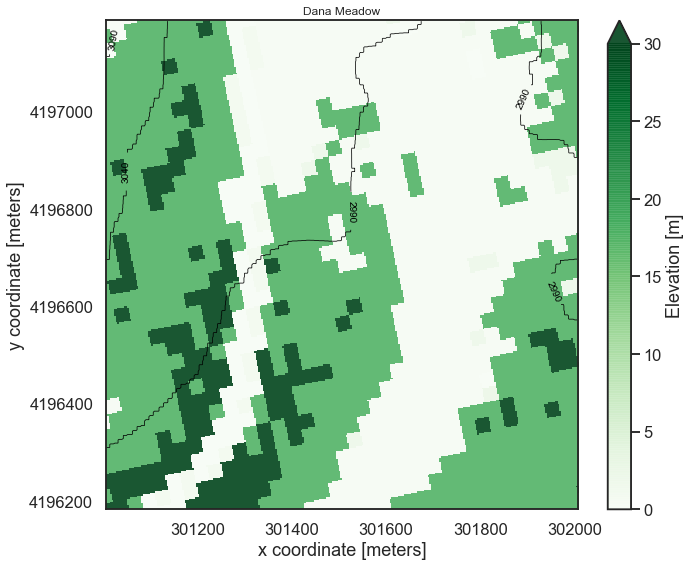

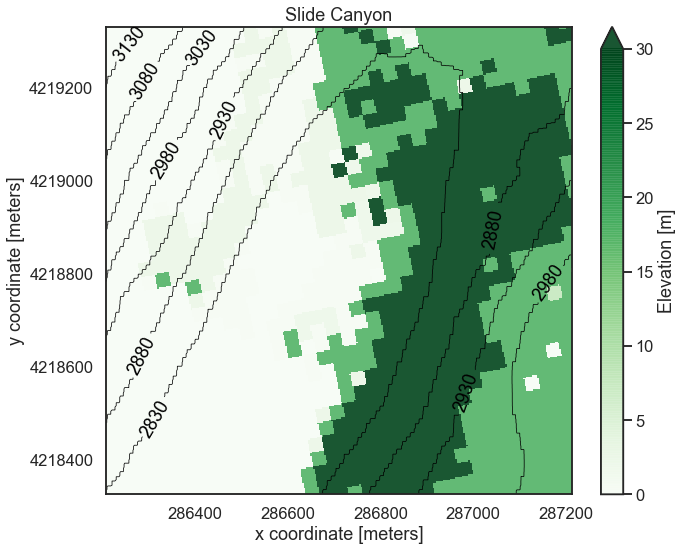

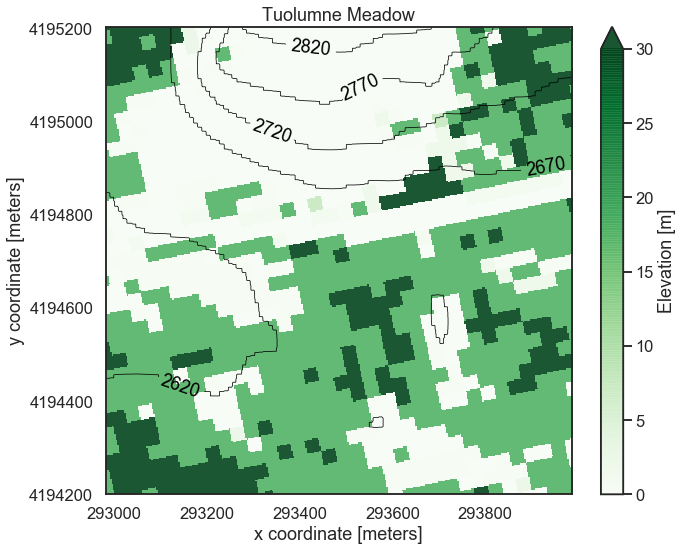

In [5]:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

for i, f in enumerate(flist):
    
    sns.set_style('white') # set up seaborn defaults (warnings w/o inside loop..?)
    sns.set_context("talk")

    print('Met Station Name:', stns_longname[i], '\n station ID:', stns[i])
    
    ds = xr.open_dataset(f); ds.close() #open DataSet in Xarray -- ds
    
    dx, dy = subregion_size(ds) #subregion size -- used in figure naming
    
    
#     plot_dem(ds, title=stns_longname[i]) #plot dem of subregion
    
    plot_veg_hgt(ds, title=stns_longname[i], ctour_int=50) #plot veg of subregion
    plt.savefig('../figs/{}_veg_{}m.png'.format(stns_lc[i], int(dx)), dpi=300)

In [6]:
#might use...reference

# # ~~~~~~ open each subregion as a single ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # open 3 different datasets
# dan = xr.open_dataset(flist[0]); dan.close()
# sli = xr.open_dataset(flist[1]); sli.close()
# tum = xr.open_dataset(flist[2]); tum.close()

#~~~~~PLANNED TO USE TERRAIN, BUT DONT NEED IT!? ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # ~~~~~TERRAIN DATA - temp for hillshade, goal is to make terrain_clean and get hill,aspect,slope all going!
# #load lidar (needed to mask terrain layers)
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU
# ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000}); ds.close()

# #load terrain layers
# path = '/Users/meganmason491/Documents/research/sierra/data/terrain/*.nc' #BSU
# fpath = glob.glob(path)
# terrain=xr.open_mfdataset(fpath, 
#                           concat_dim=None, 
#                           combine='nested', 
#                           chunks={'x':1000, 'y':1000}, 
#                           parallel=True).rename({'Band1':'hillshade'}).drop('transverse_mercator') 
# terrain.close()

# terrain_hill=np.flip(terrain.hillshade,0) #terrain needs to be flipped!
# terrain_hill=terrain_hill.where(ds.mask==1)
# terrain_hill=terrain_hill.to_dataset()
# terrain_hill.close()

# #terrain station slices
# pix = 75 #multipy by 3 to get x and y distance of box sz
# t_dan = terrain_hill.sel(x=slice(301506.-pix, 301506.+pix), y=slice(4196685.+pix, 4196685.-pix)) #x=301506.26, y=4196685.89
# t_tum = terrain_hill.sel(x=slice(293484.-pix, 293484.+pix), y=slice(4194702.+pix, 4194701.-pix)) #x=293484.72, y=4194701.07
# t_sli = terrain_hill.sel(x=slice(286708.-pix, 286710.+pix), y=slice(4218828.+pix, 4218826.-pix)) #x=286708.13, y=42188826.62 #due to rounding, made x and y have 2 pix apart


#~~~~~~~~~~~~~~ when my functions were just script.... :) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# #dem
# levels = np.arange(dan.dem.min().values,dan.dem.max().values, 5) #5m contour interval
# h = dan.dem.plot.imshow(x='x', y='y', cmap='gray', alpha=.9, cbar_kwargs={'label': 'Elevation [m]'})
# c = dan.dem.plot.contour(x='x',y='y', levels=levels, colors='k', linewidths=.75)
# plt.clabel(c,levels, fmt='%1.0f')
# plt.show()

# #veg
# levels = np.arange(dan.dem.min().values,dan.dem.max().values, 5) #5m contour interval
# h = dan.veg.plot.imshow(x='x', y='y', cmap='Greens', alpha=.9, vmax=30, cbar_kwargs={'label': 'Vegetation Height [m]'})
# c = dan.dem.plot.contour(x='x',y='y', levels=levels, colors='k', linewidths=.75)
# plt.clabel(c,levels, fmt='%1.0f')
# plt.show()

#~~~~~~~~~~~~~~ flatten plots~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# april 26, 2016 vs elevation
# d = dan.plot(x='dem', y='snow', col='time')
# stns = ['dan','tum','sli']

# for stn in stns:

#     plt.scatter('{}.dem.values.flatten()'.format(stn), '{}.isel(time=31).snow.values.flatten()'.format(stn))
#     plt.show()

# flt_sno = sli.snow.isel(time=31).values.flatten()
# flt_dem = sli.dem.values.flatten()
# flt_veg = sli.veg.values.flatten()

# # elevation density
# fig = plt.figure(figsize=(10, 5))
# plt.hexbin(flt_dem, flt_sno, mincnt=1)
# plt.xlabel('Elevation [m]')
# plt.ylabel('snow depth [cm]')
# plt.title('Snow depth vs elevation')
# plt.colorbar()
# plt.show()

# fig = plt.figure(figsize=(10, 5))
# plt.hexbin(flt_veg, flt_sno, mincnt=1)
# plt.xlabel('Vegetation [m]')
# plt.ylabel('snow depth [cm]')
# plt.title('Snow depth vs vegetation')
# plt.colorbar()
# plt.show()
# plt.savefig('figs/bla', dpi=300)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
